In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# import numpy as np

# # Set the paths
# input_folder = "/content/drive/MyDrive/CS 682 Project/Data/genres_original"
# output_folder = "/content/drive/MyDrive/CS 682 Project/Data/image_seg"

# # Create the output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Function to generate and save spectrogram images for 7.5-second segments
# def generate_segmented_spectrograms(audio_file, output_folder, genre_folder, segment_duration=7.5):
#     # Load audio file
#     y, sr = librosa.load(audio_file, duration=None)

#     # Calculate the number of segments
#     num_segments = int(len(y) / (sr * segment_duration))

#     for i in range(num_segments):
#         # Extract a 7.5-second segment
#         start_time = i * segment_duration
#         end_time = (i + 1) * segment_duration
#         segment = y[int(start_time * sr):int(end_time * sr)]

#         # Generate spectrogram
#         D = librosa.amplitude_to_db(np.abs(librosa.stft(segment)), ref=np.max)

#         # Plot the spectrogram
#         plt.figure(figsize=(4, 1.5))
#         librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
#         plt.axis('off')  # Turn off axis labels

#         # Save the spectrogram image in the respective class folder
#         class_folder = os.path.join(output_folder, genre_folder)
#         os.makedirs(class_folder, exist_ok=True)

#         output_file = os.path.join(class_folder, f"{os.path.basename(audio_file)[:-4]}_segment_{i}.png")
#         plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
#         plt.close()

# # Loop through each genre folder in the GTZAN dataset
# for genre_folder in os.listdir(input_folder):
#     genre_path = os.path.join(input_folder, genre_folder)
#     print (genre_folder)
#     if os.path.isdir(genre_path):
#         # Loop through each audio file in the genre folder
#         for audio_file in os.listdir(genre_path):
#             print (audio_file)
#             if audio_file.endswith(".wav"):
#                 audio_path = os.path.join(genre_path, audio_file)

#                 # Call the function to generate and save segmented spectrograms
#                 generate_segmented_spectrograms(audio_path, output_folder, genre_folder)


In [ ]:
# Check GPU
!nvidia-smi

# Check RAM
!free -h


In [ ]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical


#Data Loader

In [ ]:
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Set the path to your GTZAN dataset
gtzan_path = '/content/drive/MyDrive/CS 682 Project/Data/image_seg'

# Define the class names based on the GTZAN dataset
class_names = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

data = []
labels = []

# Load images for each class
for i, class_name in enumerate(class_names):
    class_paths = glob.glob(f'{gtzan_path}/{class_name}/*.*')

    for img_path in class_paths:
        image = tf.keras.preprocessing.image.load_img(img_path, color_mode='rgb', target_size=(256,256))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)



In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train_one_hot.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test_one_hot.shape}")

x_train shape: (3080, 256, 256, 3) - y_train shape: (3080, 10)
x_test shape: (771, 256, 256, 3) - y_test shape: (771, 10)


#Hyperparameter-Tuning

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 200
image_size = 256  # We'll resize input images to this size
patch_size = 64 # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 16
mlp_head_units = [2048,1024]
num_classes = 10
input_shape = (image_size,image_size,3)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 256 X 256
Patch size: 64 X 64
Patches per image: 16
Elements per patch: 12288


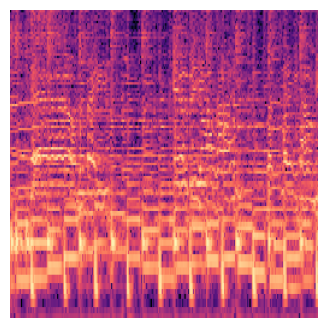

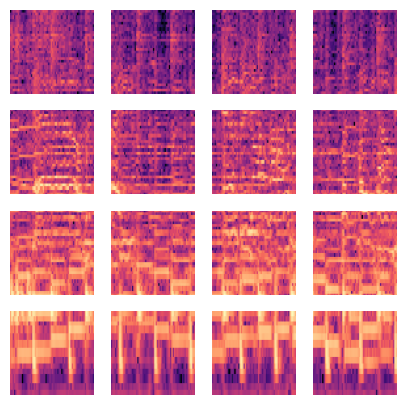

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(5,5))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
     # Normalize the patch data to the range [0, 1]
    patch_img_normalized = patch_img / 255.0

    # Choose a colormap (e.g., 'viridis', 'plasma', 'cividis', 'inferno', etc.)
    plt.imshow(patch_img_normalized.numpy(), cmap='viridis')  # Adjust the colormap as needed
    plt.axis("off")

#Vision Transformer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.

    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Change the output layer to have num_classes units
    logits = layers.Dense(num_classes, activation='softmax')(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model, x_train, y_train_one_hot, x_test, y_test_one_hot,
                   learning_rate, weight_decay, batch_size, num_epochs):
    # Define the optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Use a learning rate scheduler for better convergence
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=len(x_train) // batch_size,  # Adjust decay steps as needed
        decay_rate=0.9,
        staircase=True
    )

    # Compile the model with the optimizer and loss function
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # ModelCheckpoint callback to save the best weights
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Learning rate scheduler callback
    lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

    # Train the model
    history = model.fit(
        x=x_train,
        y=y_train_one_hot,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, lr_scheduler_callback],
    )

    # Load the best weights based on validation accuracy
    model.load_weights(checkpoint_filepath)

    # Evaluate on the test set
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test_one_hot)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier, x_train, y_train_one_hot, x_test, y_test_one_hot,
                         learning_rate, weight_decay, batch_size, num_epochs)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


11/11 [==============================] - 62s 467ms/step - loss: 2.9394 - accuracy: 0.0999 - top-5-accuracy: 0.5097 - val_loss: 2.3326 - val_accuracy: 0.1299 - val_top-5-accuracy: 0.6494 - lr: 0.0010
Epoch 2/200
11/11 [==============================] - 2s 187ms/step - loss: 2.3693 - accuracy: 0.1180 - top-5-accuracy: 0.5206 - val_loss: 2.2990 - val_accuracy: 0.1169 - val_top-5-accuracy: 0.5584 - lr: 0.0010
Epoch 3/200
11/11 [==============================] - 3s 303ms/step - loss: 2.3264 - accuracy: 0.1176 - top-5-accuracy: 0.5527 - val_loss: 2.2440 - val_accuracy: 0.2143 - val_top-5-accuracy: 0.6201 - lr: 0.0010
Epoch 4/200
11/11 [==============================] - 3s 248ms/step - loss: 2.2703 - accuracy: 0.1475 - top-5-accuracy: 0.5920 - val_loss: 2.1105 - val_accuracy: 0.2240 - val_top-5-accuracy: 0.7565 - lr: 0.0010
Epoch 5/200
11/11 [==============================] - 3s 295ms/step - loss: 2.1457 - accuracy: 0.1858 - top-5-accuracy: 0.6815 - val_loss: 1.9806 - val_accuracy: 0.2273 - v

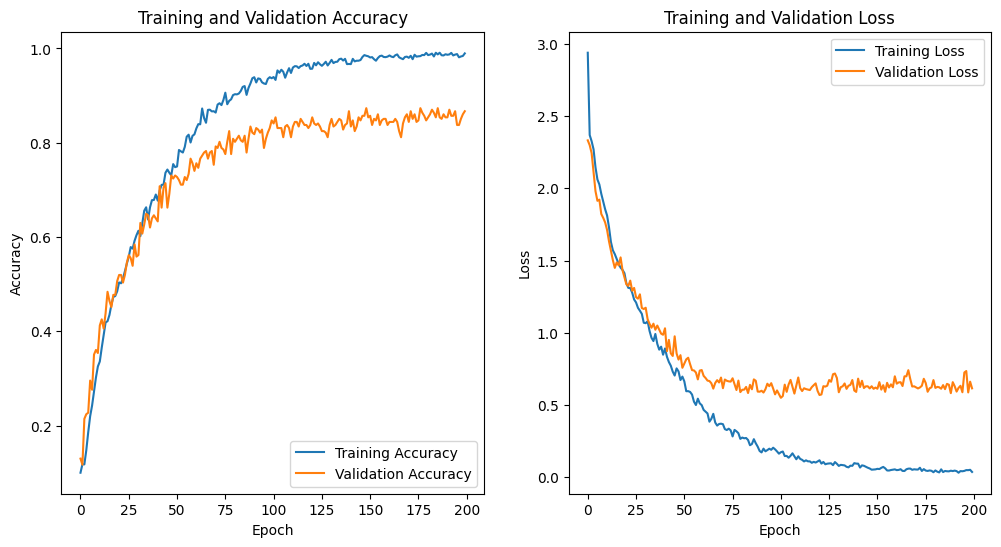

In [ ]:
    # Plot training history
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Confusion Matrix" if normalize else "Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    plt.savefig('confusion_matrix.png', format='png', dpi=1200)



25/25 [==============================] - 1s 38ms/step


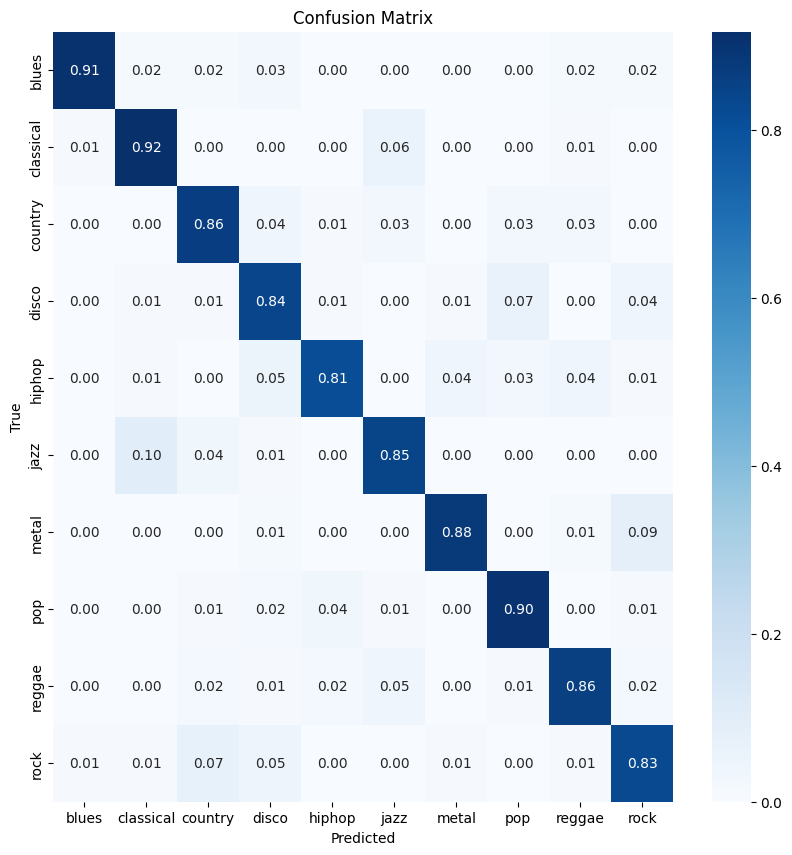

<Figure size 640x480 with 0 Axes>

In [ ]:
# Make predictions on the test set
y_pred = vit_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test_classes, y_pred_classes, class_names)

drive  sample_data  tmp  vit_classifier_model


In [ ]:
# Save the model
vit_classifier.save("vit_classifier_model")



In [ ]:
vit_classifier.summary()


#CNN

In [ ]:
n_filters = 64
num_classes = 10  # 假设有10个类别
input_shape = (128, 128, 3)

inputs = tf.keras.Input(shape=input_shape)
x = preprocessing.Resizing(128, 128)(inputs)

# 第一层使用He初始化
x = layers.Conv2D(n_filters, 3, padding='same', activation='relu',
                  kernel_initializer='he_normal',  # He初始化
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)

# 后续层继续使用He初始化
x = layers.Conv2D(n_filters * 2, 3, padding='same', activation='relu',
                  kernel_initializer='he_normal',  # He初始化
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(n_filters * 4, 3, padding='same', activation='relu',
                  kernel_initializer='he_normal',  # He初始化
                  kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu',
                 kernel_initializer='he_normal')(x)  # He初始化
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu',
                 kernel_initializer='he_normal')(x)  # He初始化

outputs = layers.Dense(num_classes, activation='softmax')(x)



In [ ]:
model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

In [ ]:
epochs = 200

history = model.fit(x=x_train,
                    y=y_train_one_hot,
                    validation_data=(x_val, y_val_one_hot),
                    epochs=epochs,
                    shuffle=True)

In [ ]:
model.evaluate(x=x_test, y=y_test_one_hot)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 训练和验证的损失
loss = history.history['loss']
val_loss = history.history['val_loss']

# 确保 epochs_range 与您训练轮次的数量一致
epochs_range = range(len(acc))  # 假设 acc 长度代表了训练轮次的数量

# 绘制准确率和损失图
plt.figure(figsize=(12, 6))

# 绘制准确率
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 绘制损失
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, normalize=True):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title("Normalized Confusion Matrix" if normalize else "Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


In [ ]:
# Make predictions on the test set
y_pred = vit_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_test_classes, y_pred_classes, class_names)